In [1]:
import os
import io
import tarfile
import json

from urllib.request import urlretrieve

In [2]:
from tqdm import tqdm
import PIL
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
repacked_etl9b_archive_dl_url = 'https://github.com/ichisadashioko/etlcdb/releases/download/v0.0.5/repacked_etl9b.tar.gz'
repacked_etl9b_archive_fpath = os.path.basename(repacked_etl9b_archive_dl_url)

In [4]:
def download_reporthook(block_number, read_size, total_file_size):
#     print(block_number, read_size, total_file_size)
    bytes_downloaded = block_number * read_size
    print(repr(bytes_downloaded) + '/' + repr(total_file_size), end='\r')

if not os.path.exists(repacked_etl9b_archive_fpath):
    print('Downloading ' + repacked_etl9b_archive_fpath)
    print('from ' + repacked_etl9b_archive_dl_url)

    urlretrieve(
        url=repacked_etl9b_archive_dl_url,
        filename=repacked_etl9b_archive_fpath,
        reporthook=download_reporthook,
    )

In [5]:
extract_dirname = 'repacked_etl9b'

if not os.path.exists(extract_dirname):
    os.makedirs(extract_dirname)

packed_images_fpath = os.path.join(extract_dirname, 'images.bin')
metadata_fpath = os.path.join(extract_dirname, 'metadata.tsv')

tar_ref = tarfile.open(repacked_etl9b_archive_fpath, 'r:gz')

if not os.path.exists(packed_images_fpath):
    print('inflating ' + packed_images_fpath)
    entry_ref = tar_ref.getmember('repacked_etl9b/images.bin')
    open(packed_images_fpath, mode='wb').write(tar_ref.extractfile(entry_ref).read())

if not os.path.exists(metadata_fpath):
    print('inflating ' + metadata_fpath)
    entry_ref = tar_ref.getmember('repacked_etl9b/metadata.tsv')
    open(metadata_fpath, mode='wb').write(tar_ref.extractfile(entry_ref).read())

tar_ref.close()

# import metadata from the `tsv` file

In [6]:
metadata_tsv_bs = open(metadata_fpath, mode='rb').read()
len(metadata_tsv_bs)

32071952

In [7]:
metadata_tsv_str = metadata_tsv_bs.decode('utf-8')
len(metadata_tsv_str)

30851480

In [8]:
del metadata_tsv_bs

In [9]:
metadata_tsv_lines = metadata_tsv_str.split('\n')
print(len(metadata_tsv_lines))

610238


In [10]:
del metadata_tsv_str

In [11]:
metadata_tsv_lines[0]

'char\tdataset_source\twidth\theight\tseek_start\tseek_end\tsheet_number\tjis_reading'

In [12]:
metadata_tsv_lines[1]

'あ\tETL9B/ETL9B_1\t64\t63\t0\t266\t1\tA.HI'

In [13]:
header = metadata_tsv_lines[0].split('\t')
num_cols = len(header)
num_cols

8

In [14]:
header

['char',
 'dataset_source',
 'width',
 'height',
 'seek_start',
 'seek_end',
 'sheet_number',
 'jis_reading']

In [15]:
ktoi = {header[i]: i for i in range(num_cols)}
ktoi

{'char': 0,
 'dataset_source': 1,
 'width': 2,
 'height': 3,
 'seek_start': 4,
 'seek_end': 5,
 'sheet_number': 6,
 'jis_reading': 7}

In [16]:
line_idx = 0

record_list = []

for tsv_line in tqdm(metadata_tsv_lines):
    if line_idx == 0:
        # skip header row
        pass
    elif len(tsv_line) == 0:
        # empty row / last line
        pass
    else:
        data_cells = tsv_line.split('\t')
        if len(data_cells) != num_cols:
            print('unknown format at line ' + repr(line_idx))
        else:
            record = {
                'char': data_cells[ktoi['char']],
                'dataset_source': data_cells[ktoi['dataset_source']],
                'width': int(data_cells[ktoi['width']]),
                'height': int(data_cells[ktoi['height']]),
                'seek_start': int(data_cells[ktoi['seek_start']]),
                'seek_end': int(data_cells[ktoi['seek_end']]),
            }
            
            record_list.append(record)

    line_idx += 1

100%|██████████████████████████████████████████████████████████████████████| 610238/610238 [00:02<00:00, 304123.20it/s]


In [17]:
len(record_list)

610236

In [18]:
record_list[0]

{'char': 'あ',
 'dataset_source': 'ETL9B/ETL9B_1',
 'width': 64,
 'height': 63,
 'seek_start': 0,
 'seek_end': 266}

In [19]:
del metadata_tsv_lines

In [20]:
sample_record = record_list[0]
sample_record

{'char': 'あ',
 'dataset_source': 'ETL9B/ETL9B_1',
 'width': 64,
 'height': 63,
 'seek_start': 0,
 'seek_end': 266}

In [21]:
packed_images_infile = open(packed_images_fpath, 'rb')

In [22]:
seek_start = sample_record['seek_start']
seek_end = sample_record['seek_end']

png_image_data_len = seek_end - seek_start

packed_images_infile.seek(seek_start)

png_image_data = packed_images_infile.read(png_image_data_len)
len(png_image_data)

266

In [23]:
packed_images_infile.close()

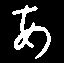

In [24]:
buffer = io.BytesIO(png_image_data)
pil_image = PIL.Image.open(buffer)
pil_image

In [25]:
np_image = np.array(pil_image, dtype=np.uint8)
np_image.shape

(63, 64)

In [26]:
height, width = np_image.shape[:2]
height, width

(63, 64)

In [27]:
np.min(np_image)

0

In [28]:
np.max(np_image)

1

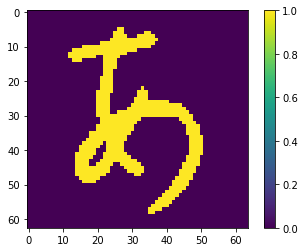

In [29]:
plt.imshow(np_image)
plt.colorbar()

In [30]:
left_pos = 0
right_pos = width - 1
top_pos = 0
bottom_pos = height - 1

stop_flag = False

while left_pos < width:
    for tmp_y in range(height):
        if np_image[tmp_y, left_pos] != 0:
            stop_flag = True
            
    if stop_flag:
        break

    left_pos += 1

stop_flag = False

while right_pos >= 0:
    for tmp_y in range(height):
        if np_image[tmp_y, right_pos] != 0:
            stop_flag = True
    
    if stop_flag:
        break

    right_pos -= 1

stop_flag = False

while top_pos < height:
    for tmp_x in range(width):
        if np_image[top_pos, tmp_x] != 0:
            stop_flag = True

    if stop_flag:
        break

    top_pos += 1

stop_flag = False

while bottom_pos >= 0:
    for tmp_x in range(width):
        if np_image[bottom_pos, tmp_x] != 0:
            stop_flag = True

    if stop_flag:
        break

    bottom_pos -= 1

left_pos, right_pos, top_pos, bottom_pos

(12, 50, 5, 58)

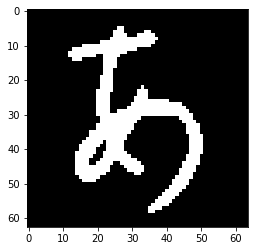

In [31]:
np_rgb_image = np.empty((height, width, 3), dtype=np.uint8)

tmp_image = np_image * 255

np_rgb_image[:,:,0] = tmp_image
np_rgb_image[:,:,1] = tmp_image
np_rgb_image[:,:,2] = tmp_image

plt.imshow(np_rgb_image)

In [32]:
np_rgb_image[0,0]

array([0, 0, 0], dtype=uint8)

In [33]:
np_rgb_image[0,0].shape

(3,)

In [34]:
border_color = np.array([255, 0, 0], dtype=np.uint8)
border_second_color = np.array([0, 255, 0], dtype=np.uint8)

In [35]:
zero_pixel = np.array([0, 0, 0], dtype=np.uint8)

In [36]:
np_rgb_image[0,0] == zero_pixel

array([ True,  True,  True])

In [37]:
np.all(_)

True

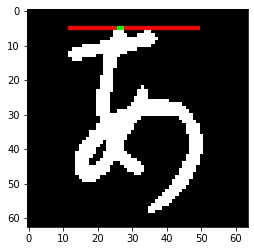

In [38]:
# draw the top line
y = top_pos

for x in range(left_pos, right_pos):
    if np.all(np_rgb_image[y,x] == zero_pixel):
        np_rgb_image[y,x] = border_color
    else:
        np_rgb_image[y,x] = border_second_color

plt.imshow(np_rgb_image)

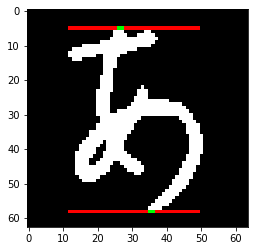

In [39]:
# draw the bottom line
y = bottom_pos

for x in range(left_pos, right_pos):
    if np.all(np_rgb_image[y,x] == zero_pixel):
        np_rgb_image[y,x] = border_color
    else:
        np_rgb_image[y,x] = border_second_color

plt.imshow(np_rgb_image)

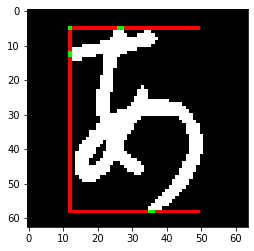

In [40]:
# draw the left line
x = left_pos

for y in range(top_pos, bottom_pos):
# for y in range(top_pos + 1, bottom_pos - 1):
    if np.all(np_rgb_image[y,x] == zero_pixel):
        np_rgb_image[y,x] = border_color
    else:
        np_rgb_image[y,x] = border_second_color

plt.imshow(np_rgb_image)

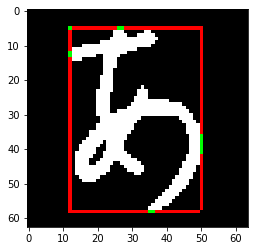

In [41]:
# draw the left line
x = right_pos

for y in range(top_pos, bottom_pos):
# for y in range(top_pos + 1, bottom_pos - 1):
    if np.all(np_rgb_image[y,x] == zero_pixel):
        np_rgb_image[y,x] = border_color
    else:
        np_rgb_image[y,x] = border_second_color

plt.imshow(np_rgb_image)

(53, 38)


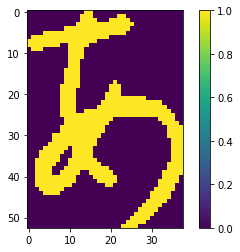

In [42]:
cropped_image = np_image[top_pos:bottom_pos, left_pos:right_pos]
print(cropped_image.shape)

plt.imshow(cropped_image)
plt.colorbar()

(54, 39)


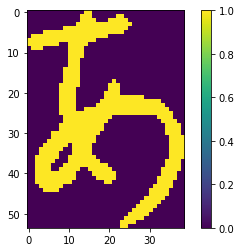

In [43]:
cropped_image = np_image[top_pos:bottom_pos+1, left_pos:right_pos+1]
print(cropped_image.shape)

plt.imshow(cropped_image)
plt.colorbar()

In [44]:
output_fpath = 'repacked_etl2_with_bounding_box_data.json'

if os.path.exists(output_fpath):
    record_list = json.loads(open(output_fpath, mode='rb').read().decode('utf-8'))
else:
    packed_images_infile = open(packed_images_fpath, 'rb')

    for record in tqdm(record_list):
        seek_start = record['seek_start']
        seek_end = record['seek_end']

        png_image_data_len = seek_end - seek_start

        packed_images_infile.seek(seek_start)

        png_image_data = packed_images_infile.read(png_image_data_len)

        buffer = io.BytesIO(png_image_data)
        pil_image = PIL.Image.open(buffer)
        np_image = np.array(pil_image, dtype=np.uint8)

        height, width = np_image.shape[:2]

        left_pos = 0
        right_pos = width - 1
        top_pos = 0
        bottom_pos = height - 1

        stop_flag = False

        while left_pos < width:
            for tmp_y in range(height):
                if np_image[tmp_y, left_pos] != 0:
                    stop_flag = True

            if stop_flag:
                break

            left_pos += 1

        stop_flag = False

        while right_pos >= 0:
            for tmp_y in range(height):
                if np_image[tmp_y, right_pos] != 0:
                    stop_flag = True

            if stop_flag:
                break

            right_pos -= 1

        stop_flag = False

        while top_pos < height:
            for tmp_x in range(width):
                if np_image[top_pos, tmp_x] != 0:
                    stop_flag = True

            if stop_flag:
                break

            top_pos += 1

        stop_flag = False

        while bottom_pos >= 0:
            for tmp_x in range(width):
                if np_image[bottom_pos, tmp_x] != 0:
                    stop_flag = True

            if stop_flag:
                break

            bottom_pos -= 1

        record['left'] = left_pos
        record['right'] = right_pos
        record['top'] = top_pos
        record['bottom'] = bottom_pos

    packed_images_infile.close()

    open(output_fpath, mode='wb').write(json.dumps(record_list, ensure_ascii=False).encode('utf-8'))

In [45]:
record_list[:3]

[{'char': 'あ',
  'dataset_source': 'ETL9B/ETL9B_1',
  'width': 64,
  'height': 63,
  'seek_start': 0,
  'seek_end': 266,
  'left': 12,
  'right': 50,
  'top': 5,
  'bottom': 58},
 {'char': 'い',
  'dataset_source': 'ETL9B/ETL9B_1',
  'width': 64,
  'height': 63,
  'seek_start': 266,
  'seek_end': 426,
  'left': 0,
  'right': 62,
  'top': 11,
  'bottom': 51},
 {'char': 'う',
  'dataset_source': 'ETL9B/ETL9B_1',
  'width': 64,
  'height': 63,
  'seek_start': 426,
  'seek_end': 638,
  'left': 21,
  'right': 42,
  'top': 0,
  'bottom': 62}]

In [46]:
bounding_box_data_list = []

for record in record_list:
    bounding_box_data_list.append([
        record['left'],
        record['right'],
        record['top'],
        record['bottom'],
    ])
    
bounding_box_np_data = np.array(bounding_box_data_list)
bounding_box_np_data.shape

(610236, 4)

In [47]:
bounding_box_df = pd.DataFrame(
    data=bounding_box_np_data,
    columns=['left', 'right', 'top', 'bottom'],
)

In [48]:
bounding_box_df.describe()

,left,right,top,bottom
count,610236.000000,610236.000000,610236.000000,610236.000000
mean,5.423135,56.945542,1.677068,60.526270
std,4.176303,4.102514,2.697848,2.532128
min,0.000000,33.000000,0.000000,33.000000
25%,2.000000,54.000000,0.000000,60.000000
50%,5.000000,57.000000,0.000000,62.000000
75%,8.000000,61.000000,3.000000,62.000000
max,29.000000,62.000000,30.000000,62.000000


In [49]:
bounding_box_df['left'].min()

0

examine some record with borders at the image's borders

In [50]:
record_with_left_0_list = []

record_idx = 0

for record in record_list:
    if record['left'] == 0:
        record_with_left_0_list.append(record_idx)
    record_idx += 1
len(record_with_left_0_list)

97859

In [51]:
record_with_left_0_list[:5]

[1, 78, 100, 115, 163]

In [52]:
def read_image_data_of_a_single_record(record: dict, packed_images_fpath: str):
    seek_start = record['seek_start']
    seek_end = record['seek_end']
    data_size = seek_end - seek_start

    infile = open(packed_images_fpath, mode='rb')
    infile.seek(seek_start)
    bs = infile.read(data_size)
    infile.close()

    buffer = io.BytesIO(bs)
    pil_image = PIL.Image.open(buffer)
    np_image = np.array(pil_image, dtype=np.uint8)

    return np_image

In [53]:
record = record_list[1]
np_image = read_image_data_of_a_single_record(record, packed_images_fpath)
np_image.shape

(63, 64)

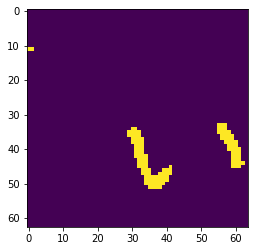

In [54]:
plt.imshow(np_image)

I think I will stop explore the data here. I will need to make another project to clean up those pixels by hand.